The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

Let's explore the data


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, normalize, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, mean_squared_error, classification_report, SCORERS, r2_score
import xgboost

In [260]:
import pandas as pd
URL = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
titanic_df = pd.read_csv(URL)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

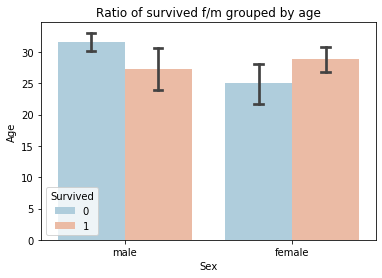

In [261]:
sns.barplot(x='Sex', y='Age', data=titanic_df, hue='Survived', palette='RdBu_r', capsize=.05)
plt.title('Ratio of survived f/m grouped by age')
plt.show();

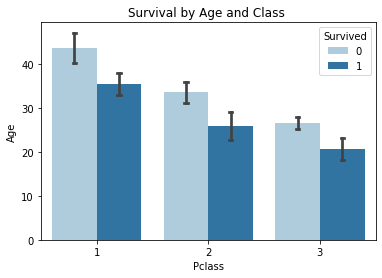

In [262]:
sns.barplot(x='Pclass', y='Age', data=titanic_df, hue='Survived', palette='Paired', capsize=.03)
plt.title('Survival by Age and Class ')
plt.show();

### cleaning and preprocessing 

In [263]:
# fill the nan values with mean of the Age 
titanic_df['Age'].fillna(titanic_df.Age.mean(), inplace=True)

# replace the gender colunms with 0, 1 values
titanic_df['Sex'] = titanic_df.Sex.replace({'male':0, 'female':1})

# Change the Age to int
titanic_df.Age = titanic_df.Age.astype('int8')

# Get the status/ position from the Name column
titanic_df['status'] = (titanic_df.Name.apply(lambda x: x.split(',')[1])).apply(lambda s: s.split('. ')[0])

# For Embarked column we need to replace 2 numerical values, with the nearest tickets 113760 with S 
# titanic_df[titanic_df.Ticket == '113760'] take S here 
# titanic_df[titanic_df.Embarked == 29.69911764705882] - We can find the values
# titanic_df.Embarked.unique() - check the unique values 
titanic_df.iloc[61, 11] = 'S'
titanic_df.iloc[829, 11] = 'S'

# Label encoding for Embarked feature
le = OneHotEncoder()

# create temp DF for label transfromation 
temp = pd.DataFrame(le.fit_transform(titanic_df[['Pclass','Embarked', 'Parch', 'SibSp']]).toarray().astype(int), \
                    columns=['Pc_1', 'Pc_2', 'Pc_3', 'Emb_S', 'Emb_C', 'Emb_Q', 'Par_1', 'Par_2', 'Par_3', 'Par_4', 'Par_5', 'Par_6', 'Par_7',
                            'Sib_1', 'Sib_0', 'Sib_3', 'Sib_4', 'Sib_2', 'Sib_5', 'Sib_8'])
# Concat both DF
df = pd.concat([titanic_df, temp], axis=1)
del temp

# drop columns Ticket, Name as well - it is noise
df.drop(['PassengerId', 'Pclass', 'Ticket', 'Embarked', 'Parch', 'SibSp', 'Name'], axis=1, inplace=True)

# normalize the Fare and Age features 
df.Fare = normalize([df.Fare, df.Age], norm='l2')[0]
df.Age = normalize([df.Fare, df.Age], norm='l2')[1]

# re index the DF
df = df.reindex()

In [264]:
# check corr between fare and class
# is is negative - so the hight fare the lower class
np.corrcoef(titanic_df.Fare, titanic_df.Pclass)[0][1]

# titanic_df.Cabin.unique() # C, E, G, D, A, B, F

-0.5494996199439074

In [265]:
# Group the DF by age
df['age_group'] = pd.qcut(df.Age, q=5, labels=[0,1,2,3,4])

# Create temp df for age group
temp_1 = pd.DataFrame(le.fit_transform(df[['age_group']]).toarray().astype(int), columns=['age_1', 'age_2', 'age_3', 'age_4', 'age_5'])

# Concat both DF
df = pd.concat([df, temp_1], axis=1)
del temp_1

# Drop the created column 
df.drop('age_group', axis=1, inplace=True)

# Fill nan with 0 for Cabin feature
df.fillna(0, inplace=True)

In [266]:
# update the labels with label enconding for status column
df.status = LabelEncoder().fit_transform(df.status).astype(int)

# update the labels for Cabin column
df.Cabin  = LabelEncoder().fit_transform(df.Cabin.astype(str)).astype(int)

### Logistic Regression 

In [267]:
# split df on train / test 
seed = 11
X_train, X_test, y_train, y_test = train_test_split(df.drop('Survived', axis=1), df.Survived, random_state=seed, test_size=0.15)

In [193]:
# init logisticReg
lr = LogisticRegression(random_state=seed)

In [194]:
# fit data
y_pred = lr.fit(X_train, y_train).predict(X_test)

/home/volodymyr/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [195]:
def score(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print('Accuracy is {} and MSE is {} and f1 is {}'.format(acc, mse, f1))
    print('------------------------------------------------------------------')
    print(classification_report(y_test, y_pred))

In [196]:
# see the model performance
score(y_test, y_pred)

Accuracy is 0.8656716417910447 and MSE is 0.13432835820895522 and f1 is 0.7954545454545455
------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        88
           1       0.83      0.76      0.80        46

    accuracy                           0.87       134
   macro avg       0.86      0.84      0.85       134
weighted avg       0.86      0.87      0.86       134



### XGB

In [197]:
# let use XBG 
xgb_model = xgboost.XGBClassifier(random_state=seed, n_jobs=-1) 

# get the prediction 
y_pred = xgb_model.fit(X_train, y_train).predict(X_test)

In [199]:
# see the performance
score(y_test, y_pred)

Accuracy is 0.835820895522388 and MSE is 0.16417910447761194 and f1 is 0.7317073170731708
------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.93      0.88        88
           1       0.83      0.65      0.73        46

    accuracy                           0.84       134
   macro avg       0.84      0.79      0.81       134
weighted avg       0.84      0.84      0.83       134



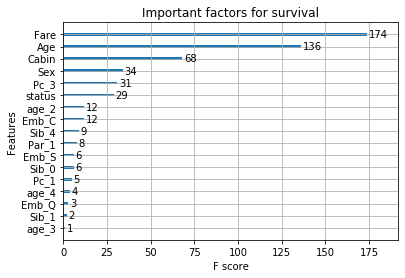

In [200]:
# plot feature importance 

xgboost.plot_importance(xgb_model)
plt.title('Important factors for survival')
plt.show();

### Hyperparams tunning

In [222]:
# imply fold shuffling
folds = 3

# create the object to shuffule
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

# setup the paramns to search 
params = {'learning_rate': np.linspace(0.001, 0.1, 5), 'max_depth': list(range(2, 13)), 'n_estimators':list(range(10, 50, 10))}


In [243]:
# create the GridSearch 
random_search = RandomizedSearchCV(xgb_model, 
            param_distributions=params, scoring='accuracy', n_jobs=-1, cv=skf.split(X_test, y_test), verbose=3, random_state=seed)

In [244]:
# Fit the model 
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:    2.1s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.2s finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7fe7f9d86ed0>,
                   error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=-1, nthread=None,
                                           objective='binary:log...
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprec

In [245]:
# Look to the best parameters 
random_search.best_params_

{'n_estimators': 30, 'max_depth': 2, 'learning_rate': 0.025750000000000002}

In [246]:
# predict results with best paramns 
y_pred = random_search.predict(X_test)

In [247]:
# see the performence
score(y_test, y_pred)

Accuracy is 0.8208955223880597 and MSE is 0.1791044776119403 and f1 is 0.6470588235294118
------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        88
           1       1.00      0.48      0.65        46

    accuracy                           0.82       134
   macro avg       0.89      0.74      0.76       134
weighted avg       0.86      0.82      0.80       134



In [255]:
# use model with best params
xgb_model = xgboost.XGBClassifier(random_state=seed, n_jobs=-1, n_estimators=30, max_depth=2, learning_rate=0.02575) 

# fit the model 
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.02575, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=30, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=11,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

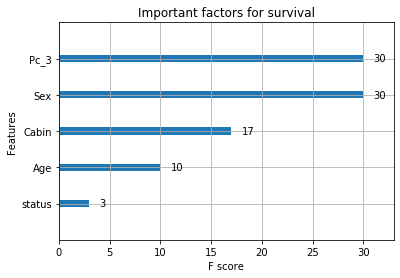

In [256]:
# plot the feature importance with best paramns 

xgboost.plot_importance(xgb_model)
plt.title('Important factors for survival')
plt.show();